# Concentration inequalities

In [1]:
import numpy as np
from scipy import stats

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')

## 1. Motivation

Given a random variable $X$, a *concentration inequality* for $X$ is one of the form

$$\mathbb{P}(|X-\mu|\geq t) \leq \delta$$

where $\mu$ is usually the mean or median of $X$, $t$ is a deviation threshold, and $\delta$ measures the mass of the distribution outside the thresholded window.

Visually, if we think of $X$ has having the density shown in the plot below, then the inequality asserts that the green area is at most $\delta$.

<img src="normal_concentration.png" align="center"/>

*Remark: We sometimes also make use of **one-sided** concentration inequalities, i.e. those of the form $\mathbb{P}(X-\mu \geq t) \leq \delta$ or $\mathbb{P}(X-\mu \leq -t) \leq \delta$.*

When $X$ is a well-known random variable, like a Gaussian, binomial, Poisson, etc., then we know the density function exactly, and so concentration inequalities are trivial. We just have to plug in the values of $\mu$ and $t$ into a function like `stats.norm.cdf` to compute the green areas.

However, in data science (and other fields that make use of probability and statistics), we often work with random variables whose distributions we don't fully know. As such, we need to use some other techniques to derive concentration inequalities for them.

### Why are we interested in concentration inequalities?

Here are a few reasons:
1. Many algorithms nowadays are randomized. We want to be able to obtain concentration inequalities for their running time.
2. We sometimes do dimension reduction using random projections. Concentration inequalities are used to guarantee that this works.
3. When we are estimating $\mu$, concentration inequalities give us **exactly valid** confidence intervals for $\mu$.
4. Bandit algorithms make use of confidence intervals to make decisions. These CIs are produced using concentration inequalities.

## 2. Markov's inequality

A large number of concentration inequalities (and all the inequalities we will see in this course) are based on Markov's inequality, which you have seen in a prior probability course. Let us do a review of how Markov's inequality works.

**Markov's inequality**: If $Z$ is a nonnegative random variable then, for $t > 0$, 

$$
\mathbb{P}(Z \ge t) ~ \le ~ \frac{\mathbb{E}(Z)}{t} 
$$

Proof: Let $p(z)$ be the density of $Z$. Then
$$\mathbb{E}[Z] = \int_0^\infty z p(z)dz$$
$$t\mathbb{P}(Z\geq t) = t\int_t^\infty p(z)dz = \int_0^\infty t\cdot 1(z\geq t) p(z) dz$$

$\mathbb{E}[Z]$ is hence the area under the blue diagonal line, weighted by $p(z)$, while $t\mathbb{P}(Z\geq t)$ is the area under the green line, weighted by $p(z)$. $\blacksquare$

<img src="Markov.png" align="center"/>

## 3. Chebyshev's inequality and higher moments

**Chebyshev's inequality**: For any random variable $Z$ with mean $\mu$ and variance $\sigma^2$, then for any $t > 0$,
$$
\mathbb{P}(\vert Z - \mu \vert \ge t) \le \frac{\mbox{Var}(Z)}{t^2}
$$


Proof: Apply Markov to $(Z - \mu)^2$:

$$
\mathbb{P}(\vert Z - \mu \vert \ge t) ~ = ~ \mathbb{P}((Z - \mu)^2 \ge t^2) ~ \le ~ \frac{\mathbb{E}(Z - \mu)^2}{t^2} ~ = ~ \frac{\mbox{Var}(Z)}{t^2} \blacksquare
$$

**Important example:** Let $Z = \frac{1}{n} \sum_{i=1}^n Z_i$ where $Z_1, Z_2, \ldots, Z_n$ are i.i.d., with mean $\mu$ and standard deviation $\sigma$. Then $\mathbb{E}(Z) = \mu$, $\mbox{Var}(Z) = \sigma^2/n$, and

$$
\mathbb{P}(\vert Z - \mu \vert \ge t) ~ \le ~ \frac{\sigma^2}{nt^2}
$$

Chebyshev uses Markov's inequality with the 2nd moment (variance). There is no reason why we need to stick with the 2nd moment.

**Higher moment bounds**: For $k = 1, 2, \ldots$,

$$
\mathbb{P}(\vert Z - \mu \vert \ge t) ~ \leq ~ \frac{\mathbb{E}(\vert Z - \mu \vert^k)}{t^k}
$$

Pf: The left hand side can be written as $\mathbb{P}(\vert Z - \mu \vert^k \ge t^k)$. Again, apply Markov. $\blacksquare$

The numerator is generally not easy to calculate (especially in the important example above). Also, even if it were easy to calculate, it's not clear which value of $k$ we should choose to get the tightest bound.

## 4. Moment generating function and Chernoff's method

Recall from elementary calculus that the exponential function, $e^x$, can be expanded in a Taylor series:

$$
e^z = 1 + z + \frac{1}{2} z^2 + \frac{1}{6} z^3 + \frac{1}{24} z^4 + \cdots,
$$

so if we consider the expectation $\mathbb{E}(e^Z)$, we are effectively getting all of the moments, bundled up in 
a particular way:

$$
\mathbb{E}(e^Z) = 1 + \mathbb{E}(Z) + \frac{1}{2} \mathbb{E}(Z^2) + \frac{1}{6} \mathbb{E}(Z^3) + \frac{1}{24} \mathbb{E}(Z^4) + \cdots,
$$

So it makes sense to consider the *moment generating function* $M_Z$, defined by

$$
M_Z(\lambda ) ~ = ~ \mathbb{E}(e^{\lambda Z}),
$$

where the additional parameter $\lambda$ gives us some amount of control over
which particular moments to favor.  Operationally, we simply set $\lambda$ to give us
the tightest bounds.  This is easier than choosing $k$ to give us the tightest bound because
we can use calculus.

- **The mgf and tails**
    - If the $M_Z(\lambda)$ is finite for a positive value of $\lambda$, that tells you the right hand tail of $Z$ is not very heavy.
    - If the $M_Z(\lambda)$ is finite for a negative value of $\lambda$, that tells you the left hand tail of $Z$ is not very heavy.
    - So the mgf is a natural function to consider for tail bounds.

### Chernoff's Method ###

For fixed $\lambda \ge 0$, the function $g(z) = e^{\lambda z}$ is an increasing function of $z$. So apply Markov to $e^{\lambda Z}$ for a nonnegative $\lambda$:

$$
\mathbb{P}(Z \ge t) ~ = ~ \mathbb{E}(e^{\lambda Z} \ge e^{\lambda t}) ~ \le ~
\frac{\mathbb{E}(e^{\lambda Z})}{e^{\lambda t}} ~ = ~ \frac{M_Z(\lambda)}{e^{\lambda t}}
$$

This is a family of bounds, one for each positive $\lambda$. To get the best of these bounds, minimize over all nonnegative $\lambda$:

$$
\mathbb{P}(Z \ge t) ~ \leq ~ \min_{\lambda \ge 0} \frac{M_Z(\lambda)}{e^{\lambda t}}
$$

## 5. Chernoff's method and Gaussian random variables

We now apply Chernoff's method to Gaussian random variables. Let $X \sim \mathcal{N}(\mu, \sigma^2)$. Then $Z = X - \mu \sim \mathcal{N}(0, \sigma^2)$ and has mgf $M_Z(\lambda) = e^{\sigma^2 \lambda^2/2}$. So for $\lambda \ge 0$,

$$
\mathbb{P}(X - \mu > t) ~ \le ~ \min_{\lambda \geq 0} \exp \big{(} \frac{\sigma^2 \lambda^2}{2} - \lambda t \big{)}
$$

How do we optimize this in $\lambda$? Recognize that since $\exp(x)$ is an increasing function, we have
$$
\min_{\lambda \geq 0} \exp \big{(} \frac{\sigma^2 \lambda^2}{2} - \lambda t \big{)} = \exp \big{(}\min_{\lambda \geq 0} \left\{\frac{\sigma^2 \lambda^2}{2} - \lambda t \right\} \big{)}.
$$

The quantity in the exponent is a quadratic function $f(\lambda)$, and can be minimized using the quadratic formula to get $\lambda^* = \frac{t}{\sigma^2}$, and $f(\lambda^*) = \frac{-t^2}{2\sigma^2}$.

Putting everything together, we get
$$
\mathbb{P}(X-\mu > t) ~\leq ~\exp\left(-\frac{t^2}{2\sigma^2}\right)
$$

**Choice of $\lambda$ in bound**: The following plot shows how the bound varies with $\lambda$ for a choice of $t=5$ and $\sigma = 2$.

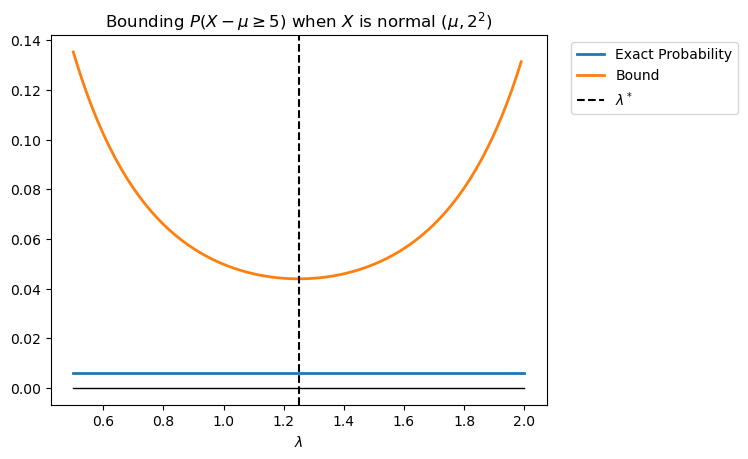

In [2]:
t = 5
sigma = 2

lam_min = 0.5
lam_max = 2
lam = np.arange(lam_min, lam_max, 0.01)

bound = np.exp(0.5*((sigma*lam)**2) - lam*t)
exact = 1 - stats.norm.cdf(t/sigma)

plt.plot([lam_min, lam_max], [exact, exact], lw=2, label = 'Exact Probability')
plt.plot(lam, bound, lw=2, label = 'Bound')
plt.plot([lam_min, lam_max], [0, 0], color='k', lw=1)
plt.axvline(5/sigma**2, c="k", ls="--", label="$\lambda^*$")
plt.legend(bbox_to_anchor=(1.4, 1))
plt.xlabel('$\lambda$')
plt.title('Bounding $P(X - \mu \geq 5)$ when $X$ is normal $(\mu, 2^2)$');

**Comparing with other probability bounds:** Because $X - \mu$ is symmetric about zero, the Chebyshev bound for a single tail is

$$
\mathbb{P}(X - \mu \ge t) ~ \le \frac{\sigma^2}{2t^2}
$$

Below, we plot the values of both bounds for $t$ between 3 and 7 for $X \sim \mathcal{N}(\mu,2^2)$. We also plot the exact value of the tail probability. Both clearly are overestimates, but the Chernoff bound is much tighter for larger values of $t$.

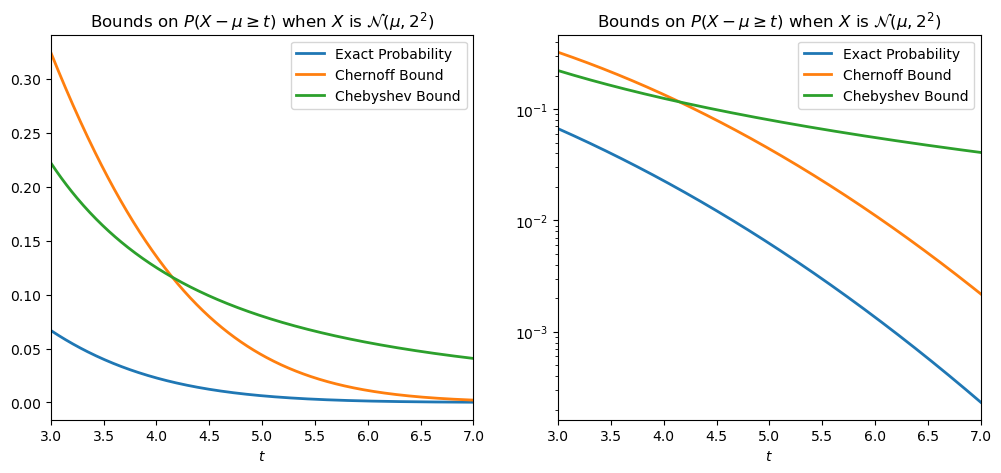

In [3]:
sigma = 2

t_min = 3
t_max = 7
t = np.arange(t_min, t_max + .01, 0.01)

chernoff = np.exp(-0.5*((t/sigma)**2))
chebyshev = 0.5 * ((sigma/t)**2)

fig, ax = plt.subplots(1,2, figsize = (12,5))
for i in range(2):
    ax[i].plot(t, 1 - stats.norm.cdf(t/sigma), label='Exact Probability', lw=2)
    ax[i].plot(t, chernoff, lw=2, label='Chernoff Bound')
    ax[i].plot(t, chebyshev, lw=2, label='Chebyshev Bound')
    ax[i].set_xlim(t_min, t_max)
    ax[i].set_xlabel('$t$')
    ax[i].legend()
    if i == 1:
        ax[i].semilogy()
    ax[i].set_title('Bounds on $P(X - \mu \geq t)$ when $X$ is $\mathcal{N}(\mu, 2^2)$')

It was kinda silly to get a tail bound this way for normal random variables, because we already know its distribution. The beauty of the argument however is that it allows us to obtain tail bounds for other random variables that we do not understand as well. This is the topic of the next section.

## 6. Chernoff's method and bounded random variables, Hoeffding's inequality

To recap, Chernoff's method involves applying Markov's inequality with the transformed variable $Y = e^{\lambda Z}$, and then optimizing the bound in $\lambda$. In the previous section, the only property of Gaussian random variables we used was the bound on the MGF $M_Z(\lambda) = e^{\sigma^2 \lambda^2/2}$. Here, we will extend the analysis to another class of random variables.

**Definition:** We say that $Z$ is *bounded* between $a$ and $b$ if $\mathbb{P}(a \leq Z \leq b) = 1$. We say that $Z$ is *centered* if $\mathbb{E}[Z] = 0$.

**Hoeffding's Lemma**: Suppose that $Z$ is a centered random variable bounded between $a$ and $b$. Then
$$
M_Z(\lambda) ~ \le ~ \exp \big{(} \frac{(b-a)^2}{8}\lambda^2 \big{)}.
$$

Proof: Can be found on Wikipedia.

This implies that we can replace $\sigma^2$ with $(b-a)^2/4$ in our calculations above and get $\mathbb{P}(Z > t) ~\leq ~\exp\left(-\frac{2t^2}{(b-a)^2}\right)$. We are however more interested in the *important example* introduced in Section 2, where we considered a sum of i.i.d. random variables. Recall that it was convenient to apply Chebyshev to that example because of the additivity of variance over independent RVs. We had
$$\text{Var}\left(\frac{1}{n}\sum_{i=1}^n X_i\right) = \frac{1}{n^2}\sum_{i=1}^n \text{Var}(X_i) = \frac{\sigma^2}{n}.$$

For the MGF, we have a similarly useful property.

**Multiplicativity of MGF for independent RVS:** Let $X_1,X_2,\ldots,X_n$ be independent RVs, and set $Z = \sum_{i=1}^n X_i$. Then
$$M_Z(\lambda) = \prod_{i=1}^n M_{X_i}(\lambda).$$

Proof: Left as exercise.

### Hoeffding's inequality

Using the previous two lemmas, we get the following important theorem

**Hoeffding's inequality:** Let $X_1,X_2,\ldots,X_n$ be independent random variables bounded between $a$ and $b$. Then
$$
\mathbb{P}\big(\frac{1}{n}\sum_{i=1}^n (X_i - \mathbb{E}[X_i]) \geq t\big) \leq \exp\left(-\frac{2nt^2}{(b-a)^2}\right).
$$
Furthermore, we have the two-sided bound
$$
\mathbb{P}\big(\big|\frac{1}{n}\sum_{i=1}^n (X_i - \mathbb{E}[X_i])\big| \geq t\big) \leq 2\exp\left(-\frac{2nt^2}{(b-a)^2}\right).
$$

Pf: By replacing $X_i$ with $X_i - \mathbb{E}[X_i]$ if necessary, we may assume that $\mathbb{E}[X_i] = 0$ for each $i$ (we do this for notational convenience). Write $Z = \sum_{i=1}^n \frac{X_i}{n}$, and observe that each term is bounded between $a/n$ and $b/n$. Then 
$$
\begin{align*}
M_Z(\lambda) &= \prod_{i=1}^n M_{X_i}(\lambda) \\
& \leq \prod_{i=1}^n \exp \big{(} \frac{(b-a)^2}{8n^2}\lambda^2 \big{)} \\
& = \exp \big{(} \frac{(b-a)^2}{8n}\lambda^2 \big{)}
\end{align*}
$$
Applying Chernoff's method:
$$
\begin{align*}
\mathbb{P}(Z > t) ~ & \le ~ \min_{\lambda \geq 0} \exp \big{(} \frac{(b-a)^2 \lambda^2}{8n} - \lambda t \big{)} \\
& = \exp\left(-\frac{2nt^2}{(b-a)^2}\right).
\end{align*}
$$
For the two sided bound, we write
$$
\mathbb{P}\big(\big|\frac{1}{n}\sum_{i=1}^n (X_i - \mathbb{E}[X_i])\big| \geq t\big)= \mathbb{P}\big(\frac{1}{n}\sum_{i=1}^n (X_i - \mathbb{E}[X_i]) \geq t \big) + \mathbb{P}\big(-\frac{1}{n}\sum_{i=1}^n (X_i - \mathbb{E}[X_i]) \geq t\big).
$$
We can bound the second term in the same way before by running Chernoff's method with $-Z$ instead. $\blacksquare$

## 7. Examples and comparison

In this section, we will apply Hoeffding's inequality to some examples, and compare its performance to other probability bounds.

Let $Z$ be a binomial $(n, p)$ proportion, that is, $Z = X/n$ where $X$ has the binomial $(n, p)$ distribution. Note that we may write $X = \sum_{i=1}^n Y_i$, where $Y_i$ is a Bernoulli random variable with expecttion $\mathbb{E}[Y_i] = p$, and which is bounded between 0 and 1. Applying Hoeffding's inequality, we get

$$
\mathbb{P}(Z - p > t) ~ \le ~ \exp(-2nt^2).
$$

Write the event in terms of the count of successes $X$, using $\mu_X$ for the expectation $np$:

$$
\mathbb{P}(Z - p \ge t) ~ = ~ \mathbb{P}(X - \mu_X \ge nt) ~ = ~ \mathbb{P}(X \ge (1+c)\mu_X)
$$

where $c = t/p$. This is a way of writing the chance that $X$ exceeds its mean by a *specified proportion*.

So let's look at $\mathbb{P}(X \ge (1+c)np)$ which we can also express as $\mathbb{P}(X - np \ge cnp)$. The graphs below are:

- the exact binomial probability $\mathbb{P}(X \ge (1+c)np)$
- the Hoeffding bound $\exp(-2nt^2)$ for $t = cp$
- the approximation using the $\mathcal{N}(np, np(1-p))$ distribution

Notice how the normal approximation is sometimes higher and sometimes lower than the exact value. The Hoeffding bound isn't particularly close but it's always above and it has the right decay rate. So you can trust it: if you construct confidence intervals for $p$ using the Hoeffding bounds as the ends, the level of confidence is guaranteed regardless of whether $n$ is large or small.

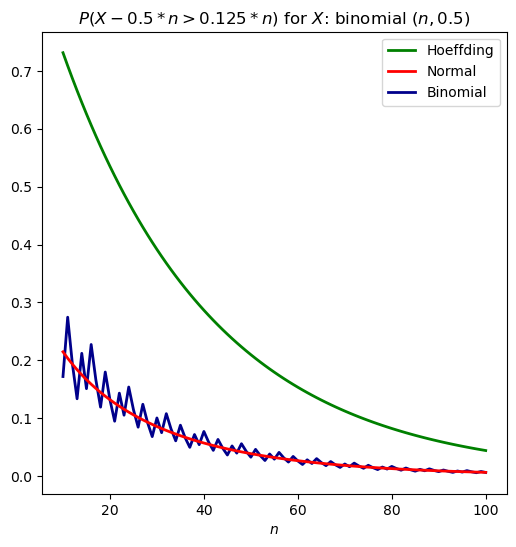

In [4]:
# You can change these parameters
c = 0.25
p = 0.5
n_array = np.arange(10, 101, 1)

# Leave the code alone below this point
t = c*p
exact = np.array([])
normal = np.array([])

for n in n_array:
    mu = n * p
    k = (1+c)*mu
    # if k an integer decrease by 1
    if k == int(k):
        k = (1+c)*mu-1
    exact = np.append(exact, 1 - stats.binom.cdf(k, n, p))
    normal = np.append(normal, 1 - stats.norm.cdf((1+c)*mu, mu, (n*p*(1-p))**0.5))

hoeff = np.exp(-2*n_array*(t**2))

plt.figure(figsize=(6, 6))
plt.plot(n_array, hoeff, color='green', lw=2, label='Hoeffding')
plt.plot(n_array, normal, color='red', lw=2, label='Normal', zorder=3)
plt.plot(n_array, exact, color='darkblue', lw=2, label='Binomial')

plt.legend()
plt.title('$P(X - {0}*n > {1}*n)$ for $X$: binomial $(n, {0})$'.format(p,p*c))
plt.xlabel('$n$');

## 8. Confidence intervals

If we are using Chernoff's inequality or concentration inequalities to construct confidence intervals, then we have to compare it to the two methods that we have already learnt: Normal approximation (i.e. observing the Central Limit Theorem $\frac{1}{\sqrt{n}}\sum_{i=1}^n X_i \Rightarrow \mathcal{N}(0,\sigma^2)$ and using the limiting distribution to get a confidence interval), or through the bootstrap.

**Comparing against normal approximation:** Normal approximation is *asymptotic*, and hence, may not be reliable for small values of $n$. This is especially the case with large deviations (i.e. for large values of $t$.) In this case, the approximation error between the comparison normal distribution and the true distribution may dwarf the tail probabilities. As seen from the last plot in the previous section, normal approximation may provide an underestimate of the tail probability, so if we want to be safe, we should use concentration inequalities.

**Comparing against bootstrap:** Bootstrap depends on data: We need to observe the data first before we can get a confidence interval. On the other hand, with concentration inequalities, we can use prior assumptions about the random variable (boundedness, variance, sample size,...) to determine the width of the intervals without even having seen any data. Furthermore, the validity of bootstrap confidence intervals is also asymptotic, and runs into the same problems as with the normal approximation.

Because of their non-asymptotic nature, concentration inequalities are often used as *theoretical tools*, i.e. they are used to prove guarantees for data science algorithms.

## 9. Going abstract: Sub-Gaussian random variables

It is sometimes helpful to work on an abstract level, as it helps us to see how tools we develop in one setting can be applied to other settings. Chernoff's method provides an example of this.

We mentioned earlier that the only property of Gaussian random variables we used was the bound on the MGF $M_Z(\lambda) = e^{\sigma^2 \lambda^2/2}$. We stated Hoeffding's Lemma, which shows that a similar MGF bound applies for bounded random variables.

A key insight in the development of machine learning theory was the recognition that it is fruitful to make the MGF bound the *definition* of a class of random variables. Then Hoeffding's inequality (and others) will apply to all random variables in this class.

**Definition:** We say that a random variable $X$ with mean $\mu$ is $\sigma$-sub-Gaussian if we have
$$
\mathbb{E}[e^{\lambda(X-\mu)}] \leq e^{\frac{\lambda^2\sigma^2}{2}}.
$$

It turns out that many random variables arising in the course of analyzing algorithms in various settings (statistics, machine learning, signal processing, numerical linear algebra,..) all belong to this class.

From the calculations in Section 5, we have the following property.

**Hoeffding bound for (sums of) sub-Gaussian RVs:** Let $X$ be $\sigma$-sub-Gaussian with mean $\mu$. Then
$$
\mathbb{P}(X-\mu > t) ~\leq ~\exp\left(-\frac{t^2}{2\sigma^2}\right)
$$

In particular, if $X_1,X_2,\ldots,X_n$ be $\sigma$-sub-Gaussian random variables with, and $a_1,a_2,\ldots,a_n$ be any numbers, then if $\mu = \mathbb{E}[\sum_{i=1}^n a_iX_i]$, we have
$$
\mathbb{P}(\sum_{i=1}^n a_i X_i-\mu > t) ~\leq ~\exp\left(-\frac{t^2}{2\sum_{i=1}^n a_i^2\sigma_i^2}\right)
$$

The second statement follows from the following two lemmas.

**Lemma:** Let $X$ be $\sigma$-sub-Gaussian, and let $a$ be any number. Then $aX$ is $|a|\sigma$-sub-Gaussian.

Pf: Assume WLOG that $\mathbb{E}[X] = 0$. We have
$$
\mathbb{E}[e^{\lambda aX}] = \mathbb{E}[e^{(\lambda a)X}] \leq e^{(\lambda a)^2\sigma^2/2} = e^{\lambda^2(a\sigma)^2/2}. \quad\blacksquare
$$

**Lemma:** Let $X_1,X_2,\ldots,X_n$ be independent random variables, with $X_i$ $\sigma_i$-sub-Gaussian for each $i$. Then $Z = \sum_{i=1}^n X_i$ is $\sigma$-sub-Gaussian, where
$$
\sigma^2 = \sum_{i=1}^n \sigma_i^2.
$$

Pf: Use the multiplicativity of the MGF.

**Examples of sub-Gaussian random variables:**
1. Gaussian random variables. If $X \sim \mathcal N (\mu, \sigma^2)$, then $X$ is $\sigma$-sub-Gaussian (see Section 5)
2. Bounded random variables. If $X$ is bounded between $a$ and $b$, then $X$ is $\sigma$-sub-Gaussian with $\sigma^2 = \frac{(b-a)^2}{4}$ (see Hoeffding's Lemma in Section 6).

**Exercise:** Let $X_1,\ldots,X_m, Y_1,\ldots,Y_n$ be independent $\sigma$-sub-Gaussian random variables. Suppose the $X_i$'s each have mean $\mu_1$, while the $Y_i$'s each have mean $\mu_2$. Then

$$
\mathbb{P}\left(\frac{1}{m}\sum_{i=1}^n X_i - \frac{1}{n}\sum_{i=1}^n Y_i > \mu_1 - \mu_2 + t\right) ~\leq ~\exp\left(-\frac{t^2}{2\sigma^2(1/m+1/n)}\right)
$$